# Introduction: Play with GLMs
During my study at [HSLU](https://www.hslu.ch/en/lucerne-school-of-business/degree-programmes/master/applied-information-and-data-science/) I have learned to use mostly [`r`](https://www.r-project.org/) when it comes to statistic and for some machine learning courses as well. When it comes to work, the most companies I have seen so far, use `Python` as their main programming language. My previous two employers used `Python` and `r`. __This article is not going to discuss which language is better, but rather focus on how to use `Python` and the library `statmodels` which seems to produce similar outputs as it would in `r`.__

One important and cool thing about the `statmodels` library is that it has a lot of data sets already included. You can find them [here](https://www.statsmodels.org/stable/datasets/index.html). The data set I use is a `r` data set from [Rdatasets](https://vincentarelbundock.github.io/Rdatasets/). In particular, the dataset from the package `modeldata` called `car_prices` is used.

```python
## Data imports
df = (
    statsmodels.api # imported as sm in following code
    .datasets
    .get_rdataset("car_prices", package='modeldata')
    .data
)
```

Another important thing about this blog post is the usage of [`Quarto`](https://quarto.org/). Quarto allowed me to write this blog post directly from a Jupyter-Notebook without any fancy and complicated transformations. For more information, please visit the quarto website.

However, let's start with the analysis. The first thing we do is to import the necessary libraries and the data set.


In [1]:
#| label: code
#| output: true
#| include: true
#| code-fold: false

## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)


## Data imports
df = (
    sm
    .datasets
    .get_rdataset("car_prices", package='modeldata')
    .data
)

# Explanatory Data Exploration
The data exploration is a crucial step before fitting a model. It allows to understand the data and to identify potential problems. In this notebook, we will explore very briefly the data, as the focus of this article is to understand and apply `statmodels`. 

In [2]:
#| echo: false

display(Markdown(
f"""
The data set contains {df.shape[0]} observations (rows) and {df.shape[1]} predictors (columns). The data set contains information about car prices and the variables are described as follows:
{'; '.join(df.columns)}.
"""
))


The data set contains 804 observations (rows) and 18 predictors (columns). The data set contains information about car prices and the variables are described as follows:
Price; Mileage; Cylinder; Doors; Cruise; Sound; Leather; Buick; Cadillac; Chevy; Pontiac; Saab; Saturn; convertible; coupe; hatchback; sedan; wagon.


In [3]:
#| output: false
#| echo: false
#| include: false

df.head()

,Price,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
0,22661.05,20105,6,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,21725.01,13457,6,2,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,29142.71,31655,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0
3,30731.94,22479,4,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,33358.77,17590,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0


First, two approximately continous variables `Price` and `Mileage` are investigated by means of graphical analysis. The following bar plots show the distribution of the two variables.

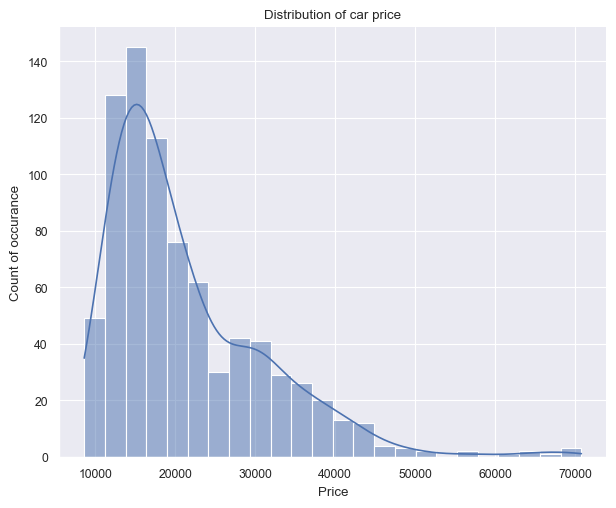

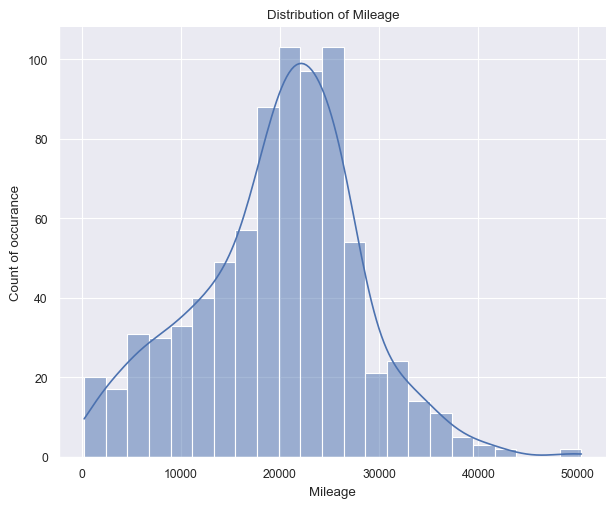

In [4]:
#| label: fig-distplot
#| layout-ncol: 2
#| fig-cap: Distribution of price and mileage variables. 
#| fig-subcap: 
#|   - "Distribution of the variable Price"
#|   - "Distribution of the variable Mileage"

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g1 = sns.displot(
    data = df,
    x = 'Price',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of car price')
plt.xlabel('Price')
plt.ylabel('Count of occurance')
plt.show(g1)

g2 = sns.displot(
    data = df,
    x = 'Mileage',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count of occurance')
plt.show(g2)

@fig-distplot-1 shows the left a right-skewed distribution with a peak around 15k$ and price values ranging from 8k dollars to 70k dollars. On the other hand, [figure -@fig-distplot-2] shows on the right a more ballanced distribution with a peak around 20k$ and price values ranging from 266 miles up to 50k miles. 

Proceeding to the next two variables, `Cylinder` and `Doors`, one can see less possible values, ranging from 

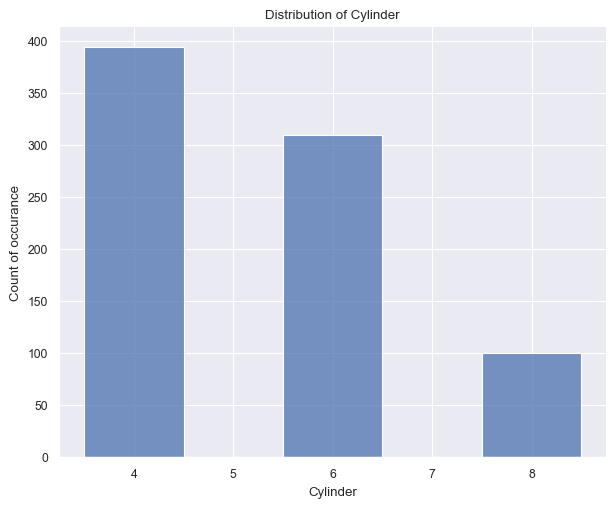

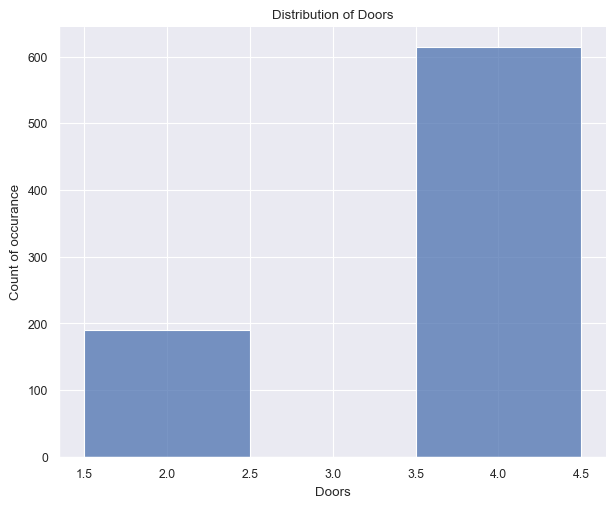

In [5]:
#| label: fig-distplot2
#| layout-ncol: 2
#| fig-cap: Distribution of cylinder and doors variables. 
#| fig-subcap: 
#|   - "Distribution of the variable cylinder"
#|   - "Distribution of the variable doors"

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g = sns.displot(
    data = df,
    x = 'Cylinder',
    discrete = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Cylinder')
plt.xlabel('Cylinder')
plt.ylabel('Count of occurance')
plt.show(g)

# plt.figure()
g = sns.displot(
    data = df,
    x = 'Doors',
    discrete = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Doors')
plt.xlabel('Doors')
plt.ylabel('Count of occurance')
plt.show(g)

The @fig-distplot2-1 surprised me quite a bit. I had anticipated the car to feature more than 8 cylinders, given that this dataset pertains to American cars. The cylinder count typically spans from 4 to 8, with the values accurately reflecting this range. It's worth noting that the number of cylinders is expected to be even.

Again surprisingly, the @fig-distplot2-2 shows that the number of doors per car. The values are either 2 or 4, with the latter being more common. This is a bit surprising, as I would have expected the number of doors to be higher for American cars (SUV). 

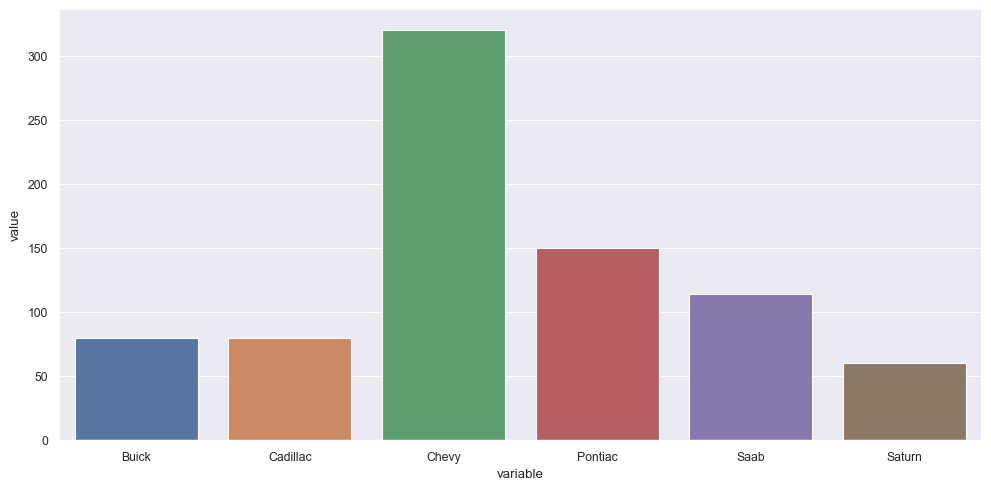

In [18]:
features = ['Buick', 'Cadillac', 'Chevy', 'Pontiac', 'Saab', 'Saturn', 'convertible', 'coupe', 'hatchback', 'sedan', 'wagon']

brands = (
    df
    [
        [brand for brand in features if brand == brand.capitalize()]
    ]
    .melt()
    .groupby('variable')
    .sum()
    .reset_index()
)

sns.catplot(
    data=brands,
    x='variable',
    y='value',
    kind='bar',
    height=5,
    aspect=2,
)

# Modeling
Modeling with `statsmodels` becomes straightforward once the formula API and provided documentation are well understood. I encountered a minor challenge in grasping the formula API, but once I comprehended it, the usage turned out to be quite intuitive. Let's delve into an understanding of the formula API. This feature enables us to employ R-style formulas for specifying models. To illustrate, when fitting a linear model, the following formula suffices:

```python
import statsmodels.formula.api as smf

model = smf.ols(
    formula='y ~ x1 + x2 + x3', 
    data=df
)
```

The formula API leverages the `patsy` package ([Patsy Package](https://patsy.readthedocs.io/en/latest/formulas.html)). It's worth noting that the formula API's potency extends to intricate models. Additionally, it's important to mention that the formula API automatically incorporates an intercept into the formula if one isn't explicitly specified. For cases where the intercept is undesired, a `-1` can be used within the formula.

With the `glm` class, a vast array of models becomes accessible importing as follows:

```python
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
```

The `fam` import is necessary for specifying the family of the model. The families available are:

In [6]:
#| echo: false
#| output: true

from IPython.display import Markdown

glms = pd.read_html(
    #'https://www.statsmodels.org/stable/glm.html',
    'https://www.statsmodels.org/stable/glm.html#families',
)

families = glms[3]

Markdown(
    (
        families
        .rename(
            columns = {
                0 : 'Name',
                1 : 'Description',
            }
        )
        .to_markdown(
            index = False
        )
    )
)

| Name                                        | Description                                                |
|:--------------------------------------------|:-----------------------------------------------------------|
| Family(link, variance[, check_link])        | The parent class for one-parameter exponential families.   |
| Binomial([link, check_link])                | Binomial exponential family distribution.                  |
| Gamma([link, check_link])                   | Gamma exponential family distribution.                     |
| Gaussian([link, check_link])                | Gaussian exponential family distribution.                  |
| InverseGaussian([link, check_link])         | InverseGaussian exponential family.                        |
| NegativeBinomial([link, alpha, check_link]) | Negative Binomial exponential family (corresponds to NB2). |
| Poisson([link, check_link])                 | Poisson exponential family.                                |
| Tweedie([link, var_power, eql, check_link]) | Tweedie family.                                            |

In [7]:
variables = df.columns.to_list()

response_variable = variables.pop(0)
variables = variables

formula = 'Price ~' + ' + '.join(variables) + ' - 1'

model1 = (
    smf
    .glm(
        formula = formula, 
        offset  = None,
        data    = df, 
        family  = fam.Gaussian(),
        missing = 'drop',
    )
    .fit()
)

print(
    model1.summary()
)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Price   No. Observations:                  804
Model:                            GLM   Df Residuals:                      789
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      8.4460e+06
Method:                          IRLS   Log-Likelihood:                -7544.8
Date:                Wed, 09 Aug 2023   Deviance:                   6.6639e+09
Time:                        23:43:38   Pearson chi2:                 6.66e+09
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Mileage        -0.1842      0.013    -14.664      

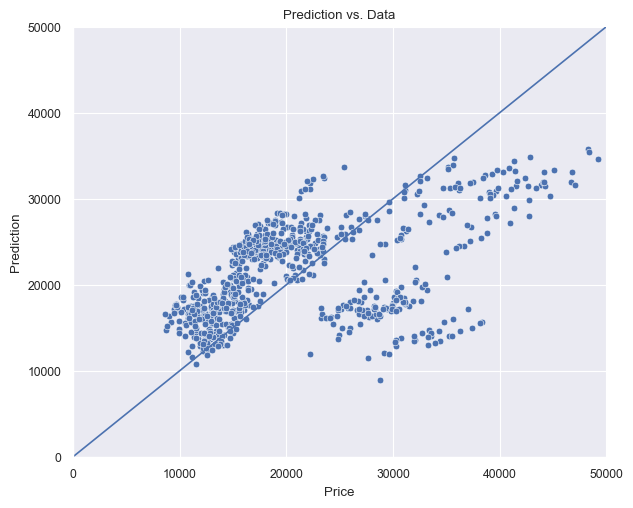

In [8]:
preds = (
    df
    .assign(
        Price_pred = lambda df: model1.params.loc['Mileage'] * df.Mileage +  model1.params.loc['Cylinder'] * df.Cylinder + model1.params.loc['Doors'] * df.Doors,
        procent_error = lambda df: df.Price_pred / df.Price,
    )
)

height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g = sns.relplot(
    data    = preds,
    x       = 'Price',
    y       = 'Price_pred',
    height  = height,
    aspect  = aspect,
    kind    = 'scatter',
)
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.axline((0,0),(1,1))
plt.title('Prediction vs. Data')
plt.show(g)